In [1]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 8
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'TeX Gyre Termes']

# Dataset visualization

In [3]:
from itertools import repeat
import lzma
import pickle

from gensim.matutils import corpus2csc, unitvec
from gensim.models import TfidfModel
import numpy as np
import scipy.sparse
from sklearn.manifold import TSNE
import sklearn.preprocessing as preprocessing
# from scikits.sparse.cholmod import cholesky

import dataset
from dataset import common_dictionary, common_embedding_matrices, pivot_worker, translate_document_worker

# with lzma.open('matrices/termsim-1-True-True-True-600.pkl.xz', 'rb') as f:
#     sparse_embedding_matrix = pickle.load(f)
# sparse_embedding_matrix = cholesky(embedding_matrix).L()
# with lzma.open('matrices/cholesky-1-True-True-True-600.pkl.xz', 'wb') as f:
#     pickle.dump(sparse_embedding_matrix, f)
with lzma.open('matrices/cholesky-1-True-True-True-600.pkl.xz', 'rb') as f:
    sparse_embedding_matrix = pickle.load(f)

dense_embedding_matrix = common_embedding_matrices[32]
dense_embedding_matrix = preprocessing.normalize(dense_embedding_matrix, norm='l2')

dataset_names = ['bbcsport', 'twitter', 'bbc', 'ohsumed', 'reuters', 'amazon', '20news']

2019-02-21 01:57:28,422 : INFO : 'pattern' package not found; tag filters are not available for English
2019-02-21 01:57:28,672 : INFO : Loading dataset from file corpora/fil8.pkl.xz.
2019-02-21 01:57:34,618 : INFO : loading projection weights from vectors/1b_1000d_vectors_e10_nonbin
2019-02-21 01:58:18,487 : INFO : loaded (60238, 1000) matrix from vectors/1b_1000d_vectors_e10_nonbin
2019-02-21 01:58:18,488 : INFO : loading projection weights from vectors/32b_200d_vectors_e10_nonbin
2019-02-21 01:58:29,066 : INFO : loaded (60238, 200) matrix from vectors/32b_200d_vectors_e10_nonbin


2019-02-21 02:04:59,537 : INFO : Loading dataset from file corpora/bbcsport_train.pkl.xz.
2019-02-21 02:04:59,617 : INFO : Loading dataset from file corpora/bbcsport_validation.pkl.xz.
2019-02-21 02:04:59,640 : INFO : Loading dataset from file corpora/bbcsport_test.pkl.xz.
2019-02-21 03:52:22,643 : INFO : Loading dataset from file corpora/twitter_train.pkl.xz.
2019-02-21 03:52:22,679 : INFO : Loading dataset from file corpora/twitter_validation.pkl.xz.
2019-02-21 03:52:22,688 : INFO : Loading dataset from file corpora/twitter_test.pkl.xz.
2019-02-21 05:49:42,458 : INFO : Loading dataset from file corpora/bbc_train.pkl.xz.
2019-02-21 05:49:42,705 : INFO : Loading dataset from file corpora/bbc_validation.pkl.xz.
2019-02-21 05:49:42,770 : INFO : Loading dataset from file corpora/bbc_test.pkl.xz.
2019-02-21 07:52:29,876 : INFO : Loading dataset from file corpora/ohsumed_train.pkl.xz.
2019-02-21 07:52:30,184 : INFO : Loading dataset from file corpora/ohsumed_validation.pkl.xz.
2019-02-21 07

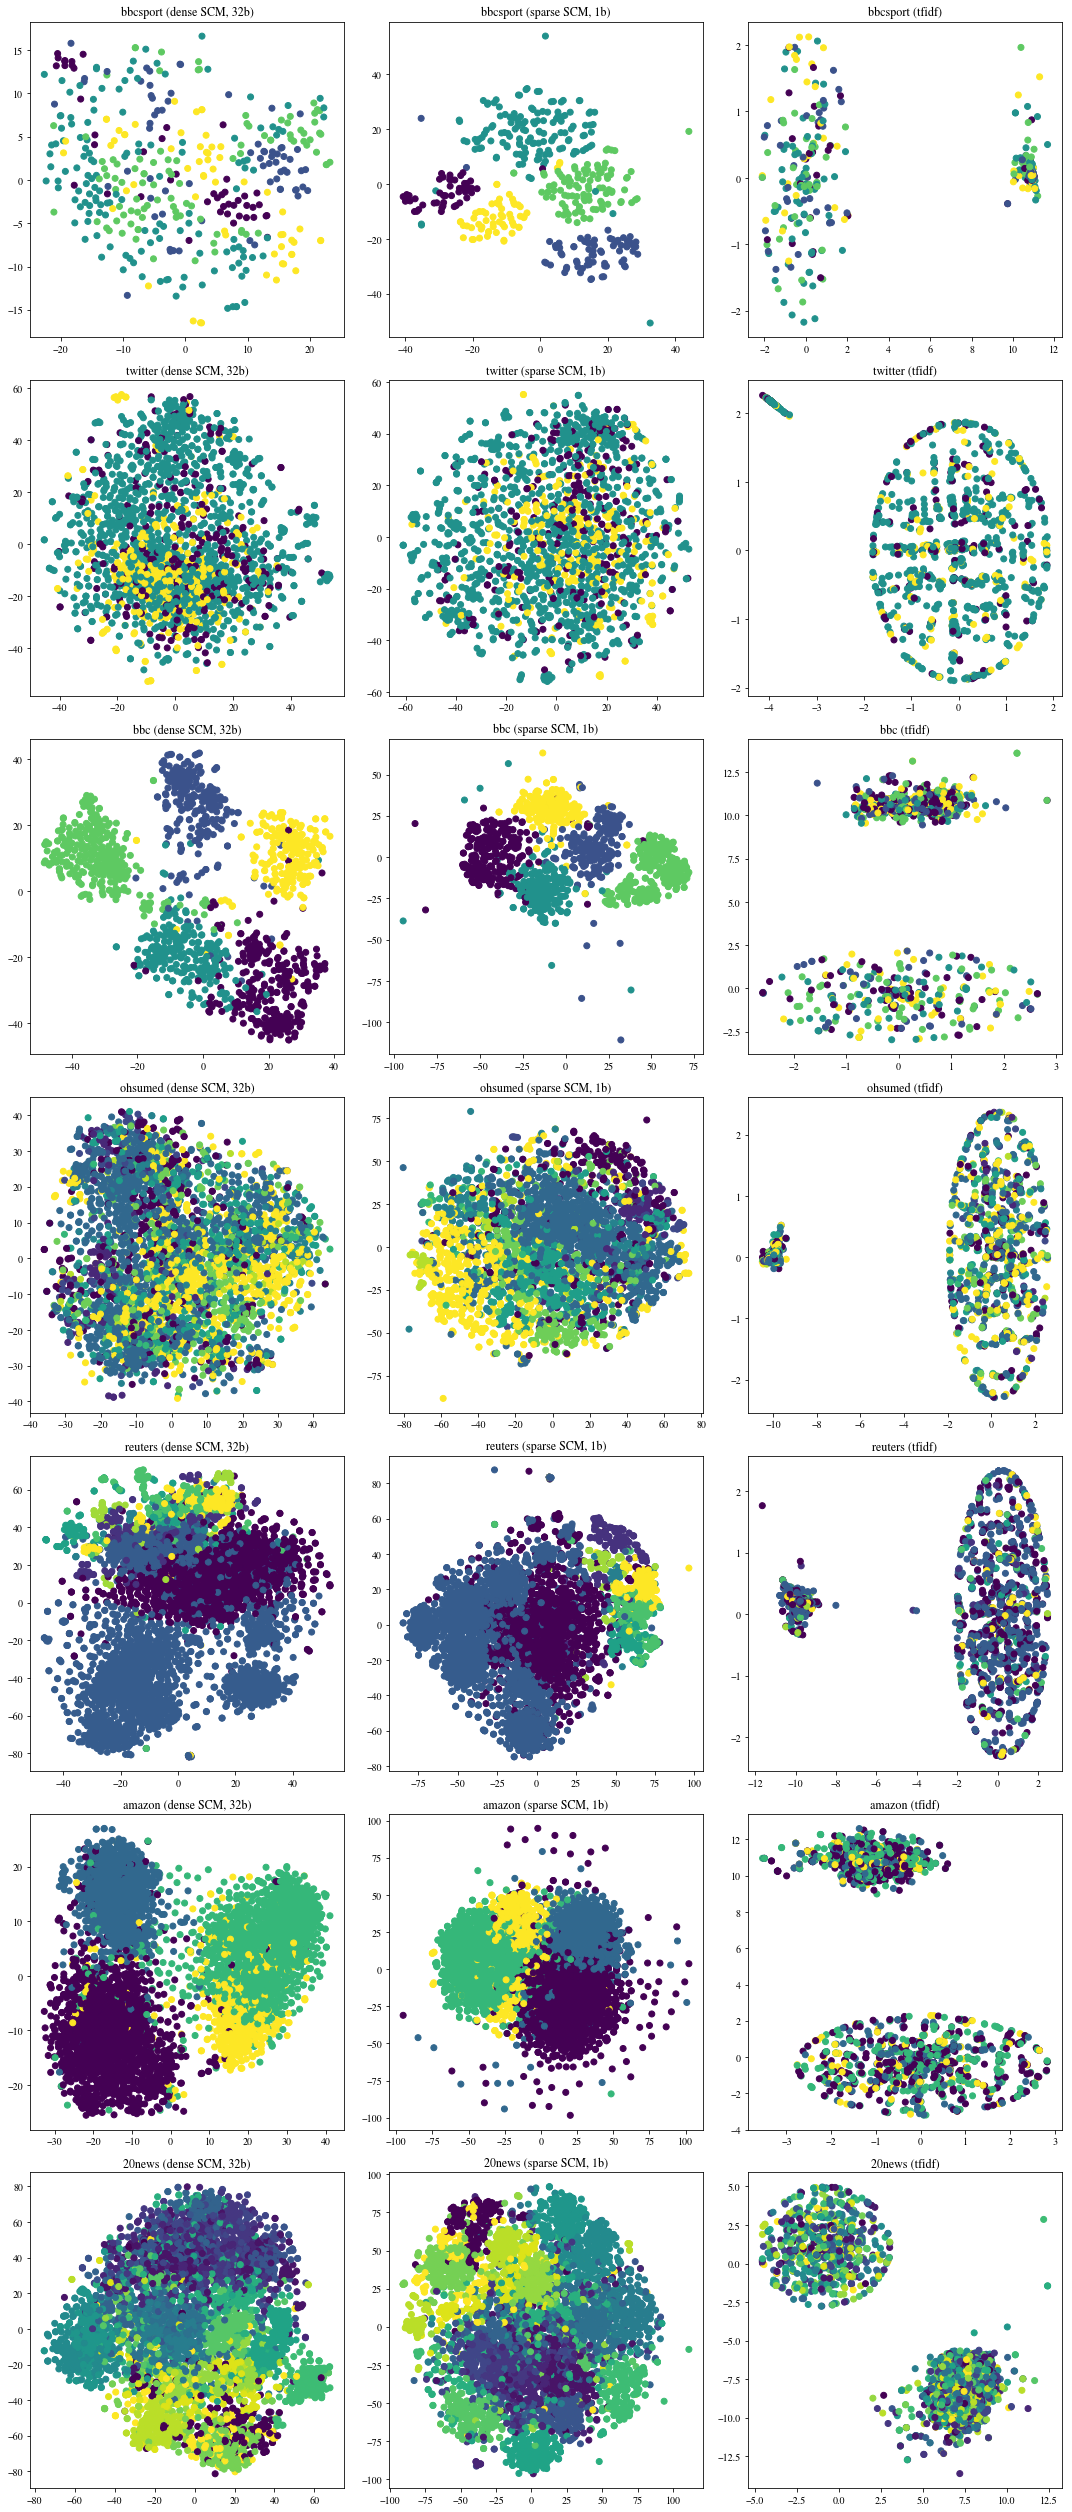

In [5]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

plt.figure(figsize=(15, 5 * len(dataset_names)))
for dataset_number, dataset_name in enumerate(dataset_names):
    train, validation, test = dataset.__dict__['load_{}'.format(dataset_name)]()
    X = train.corpus
    Y = np.array(train.target, dtype=int)
    tfidf = TfidfModel(dictionary=train.dictionary, smartirs='dtn')
    np.random.seed(42)
    sample = np.random.choice(len(X), min(len(X), 5000), replace=False)

    X_dense_soft_vsm = map(train.dictionary.doc2bow, X)
    X_dense_soft_vsm = map(pivot_worker, zip(
        tfidf[X_dense_soft_vsm],
        repeat(1.0),
        repeat(train.avgdl),
    ))
    X_dense_soft_vsm = map(translate_document_worker, zip(
        X_dense_soft_vsm,
        repeat(train.dictionary),
        repeat(common_dictionary),
    ))
    X_dense_soft_vsm = corpus2csc(X_dense_soft_vsm, len(common_dictionary))
    X_dense_soft_vsm = scipy.sparse.csc_matrix.dot(
        dense_embedding_matrix.T,
        X_dense_soft_vsm,
    ).T
    X_dense_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_dense_soft_vsm)
    X_dense_soft_vsm = X_dense_soft_vsm[sample]
    Y_dense_soft_vsm = Y[sample]
    
    ax = plt.subplot(len(dataset_names), 3, dataset_number * 3 + 1)
    ax.set_title('{} (dense SCM, 32b)'.format(dataset_name))
    ax.scatter(*X_dense_soft_vsm.T, c=Y_dense_soft_vsm)
    
    X_sparse_soft_vsm = map(train.dictionary.doc2bow, X)
    X_sparse_soft_vsm = map(pivot_worker, zip(
        tfidf[X_sparse_soft_vsm],
        repeat(1.0),
        repeat(train.avgdl),
    ))
    X_sparse_soft_vsm = map(translate_document_worker, zip(
        X_sparse_soft_vsm,
        repeat(train.dictionary),
        repeat(common_dictionary),
    ))
    X_sparse_soft_vsm = corpus2csc(X_sparse_soft_vsm, len(common_dictionary))
    X_sparse_soft_vsm_norm = X_sparse_soft_vsm.T.dot(sparse_embedding_matrix).multiply(X_sparse_soft_vsm.T).sum(axis=1).T
    X_sparse_soft_vsm = X_sparse_soft_vsm.multiply(scipy.sparse.csr_matrix(1 / np.sqrt(X_sparse_soft_vsm_norm)))
    X_sparse_soft_vsm = scipy.sparse.csc_matrix.dot(sparse_embedding_matrix.T, X_sparse_soft_vsm).T.todense()
    X_sparse_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_sparse_soft_vsm)
    X_sparse_soft_vsm = X_sparse_soft_vsm[sample]
    Y_sparse_soft_vsm = Y[sample]
    
    ax = plt.subplot(len(dataset_names), 3, dataset_number * 3 + 2)
    ax.set_title('{} (sparse SCM, 1b)'.format(dataset_name))
    ax.scatter(*X_sparse_soft_vsm.T, c=Y_sparse_soft_vsm)

    X_bow = map(train.dictionary.doc2bow, X)
    X_bow = map(pivot_worker, zip(
        tfidf[X_bow],
        repeat(1.0),
        repeat(train.avgdl),
    ))
    X_bow = map(translate_document_worker, zip(
        X_bow,
        repeat(train.dictionary),
        repeat(common_dictionary),
    ))
    X_bow = corpus2csc(X_bow, len(common_dictionary)).todense()
    X_bow = TSNE(n_components=2, metric='cosine').fit_transform(X_bow)
    X_bow = X_bow[sample]
    Y_bow = Y[sample]
    
    ax = plt.subplot(len(dataset_names), 3, dataset_number * 3 + 3)
    ax.set_title('{} (tfidf)'.format(dataset_name))
    ax.scatter(*X_bow.T, c=Y_bow)

plt.tight_layout()
plt.savefig('figures/classification-datasets.pdf')
plt.show()

# Sparse Term Similarity Matrices

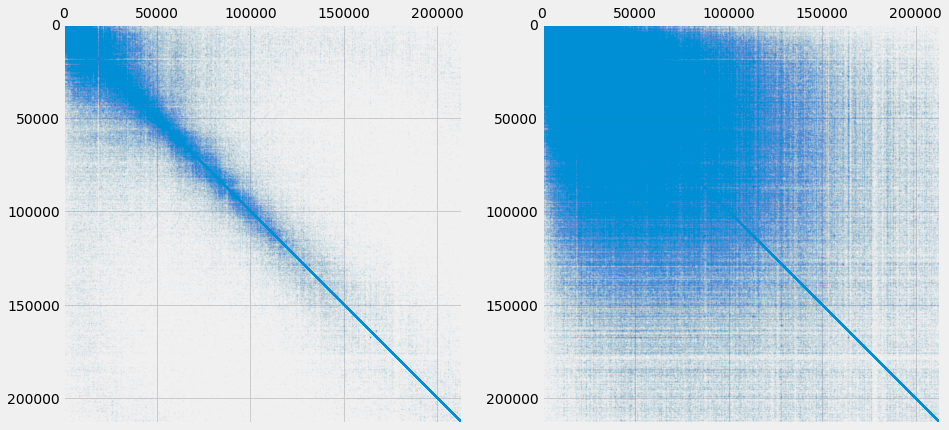

In [159]:
from scipy.sparse import coo_matrix

from common import cached_sparse_term_similarity_matrix
    
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(121)
embedding_matrix = cached_sparse_term_similarity_matrix('32-True-True-True-600')
ax.spy(embedding_matrix, markersize=0.005)

ax = fig.add_subplot(122)
embedding_matrix = cached_sparse_term_similarity_matrix('1-True-True-True-600')
ax.spy(embedding_matrix, markersize=0.005)

plt.show()

# Confusion Matrices

2019-02-22 11:43:22,380 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-02-22 11:43:22,404 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-02-22 11:43:22,524 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


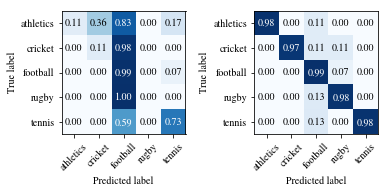

In [8]:
from itertools import product

import numpy as np

from common import ClassificationResult

alpha = 0.6
classes = ('athletics', 'cricket', 'football', 'rugby', 'tennis')
tick_marks = np.arange(len(classes))

fig = plt.figure(figsize=(5.5, 5.5))

ax = fig.add_subplot(121)
result = ClassificationResult.from_file('bbcsport-dense_soft_vsm-tfidf-inner_product-32')
confusion_matrix = result.confusion_matrix / result.confusion_matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix = confusion_matrix**alpha
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
thresh = confusion_matrix.max() / 2.0
for i, j in product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    text = format(confusion_matrix[i, j], '.2f')
    color = "white" if confusion_matrix[i, j] > thresh else "black"
    plt.text(j, i, text, horizontalalignment="center", verticalalignment="center", color=color)
plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = fig.add_subplot(122)
result = ClassificationResult.from_file('bbcsport-sparse_soft_vsm-tfidf-inner_product-1')
confusion_matrix = result.confusion_matrix / result.confusion_matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix = confusion_matrix**alpha
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
thresh = confusion_matrix.max() / 2.0
for i, j in product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    text = format(confusion_matrix[i, j], '.2f')
    color = "white" if confusion_matrix[i, j] > thresh else "black"
    plt.text(j, i, text, horizontalalignment="center", verticalalignment="center", color=color)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.savefig('figures/classification-confusion_matrices.pdf')
plt.show()